# Mask R-CNN - Cityscapes inference

## Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import modules

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath("/content/drive/MyDrive/cityscapes/utils")
sys.path.append(ROOT_DIR)

import utils_cityscapes   # Matterport Mask R-CNN set-up
from utils_cityscapes import CityscapesConfig, CityscapesDataset, color_splash

from mrcnn import model as modellib, utils, visualize

## Configurations

In [ ]:
class InferenceConfig(CityscapesConfig):
    USE_MINI_MASK = False

config_inference = InferenceConfig()
config_inference.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        150
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  2048
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [1024 2048    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Dataset

In [ ]:
DATASET_DIR = "/content/drive/MyDrive/cityscapes/dataset/Semantic"

# Testset
dataset_test = CityscapesDataset()
dataset_test.load_cityscapes(DATASET_DIR, "Test")
dataset_test.prepare()

class_names = dataset_test.class_names

## Model

In [ ]:
MODELS_DIR = "/content/drive/MyDrive/cityscapes/models"
MODEL_DIR = os.path.join(MODELS_DIR, "inference")

WEIGHTS_PATH = os.path.join(MODELS_DIR, "from_coco/training/lr00006_wd006_m98_aug_flip_crop/cityscapes20210617T0726/mask_rcnn_cityscapes_0018.h5")

In [ ]:
model = modellib.MaskRCNN(mode="inference", config=config_inference, model_dir=MODEL_DIR)

model.load_weights(WEIGHTS_PATH, by_name=True)

Re-starting from epoch 18


## Inference

In [ ]:
image_id = np.random.choice(dataset_test.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_test, config_inference, image_id)

results = model.detect([image], verbose=0)
r = results[0]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
print(dataset_test.image_info[image_id]['id'])

munster_000119_000019


## Show results

### RoIs

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 523776, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.02054  max:    1.02858  float32
refined_anchors          shape: (1, 6000, 4)          min:    0.00670  max:    1.01704  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00670  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 3070.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.06879  max:    1.00000  float32


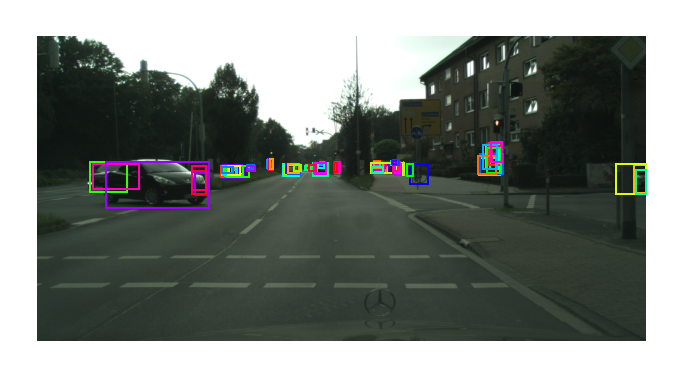

In [ ]:
limit = 100
h, w = config_inference.IMAGE_SHAPE[:2]

proposals = rpn['proposals'][0, :limit]* np.array([h,w,h,w])

visualize.draw_boxes(image, refined_boxes=proposals)

### Boxes

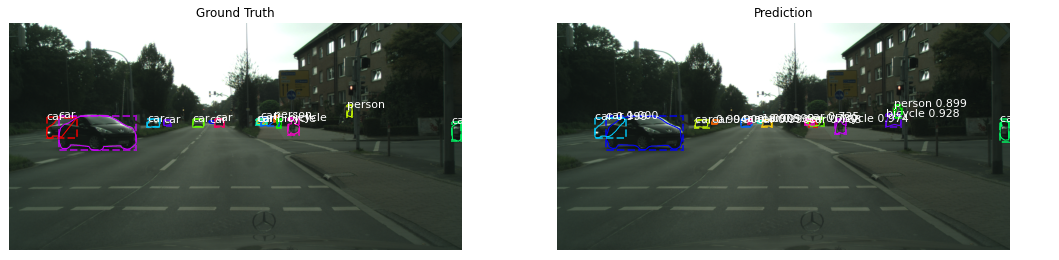

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10))

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, class_names, title="Ground Truth", show_mask=False, show_bbox=True, ax=ax1)
visualize.display_instances(image, r["rois"], r['masks'], r["class_ids"], class_names, r["scores"], title="Prediction", show_mask=False, show_bbox=True, ax=ax2)

plt.show()

### Masks

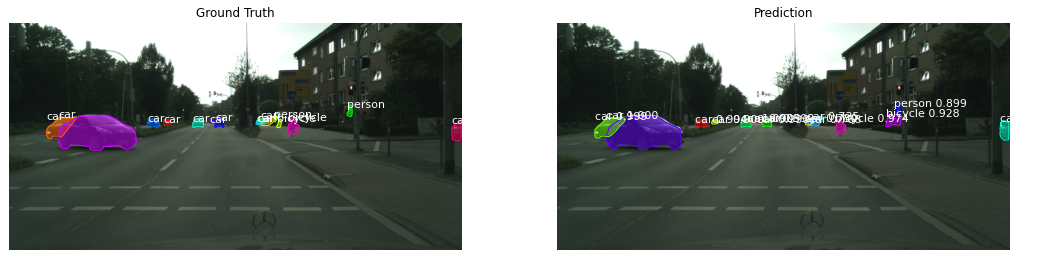

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10))

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, class_names, title="Ground Truth", show_mask=True, show_bbox=False, ax=ax1)
visualize.display_instances(image, r["rois"], r['masks'], r["class_ids"], class_names, r["scores"], title="Prediction", show_mask=True, show_bbox=False, ax=ax2)

plt.show()

#### Differences

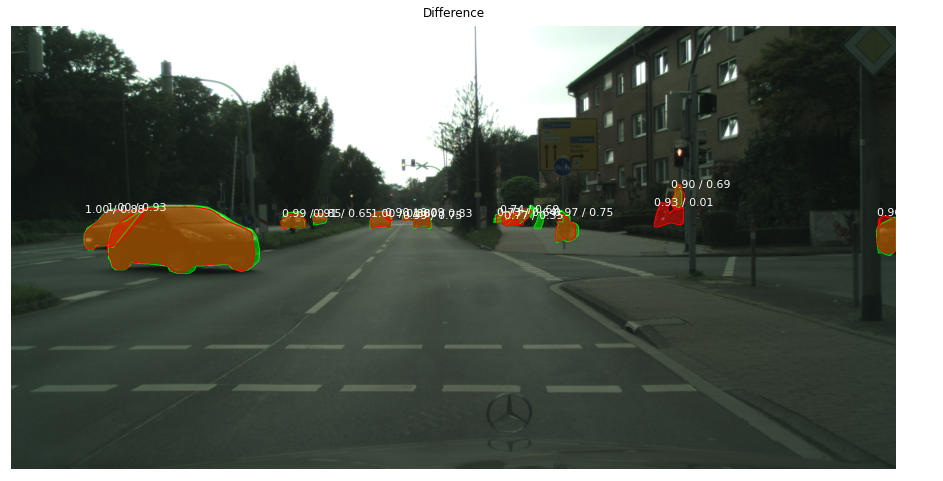

In [ ]:
visualize.display_differences(image, 
                              gt_bbox, gt_class_id, gt_mask,
                              r["rois"], r["class_ids"], r["scores"], r['masks'],
                              class_names, title="Difference",
                              show_mask=True, show_box=False,
                              iou_threshold=0.5, score_threshold=0.5)

### Color splash

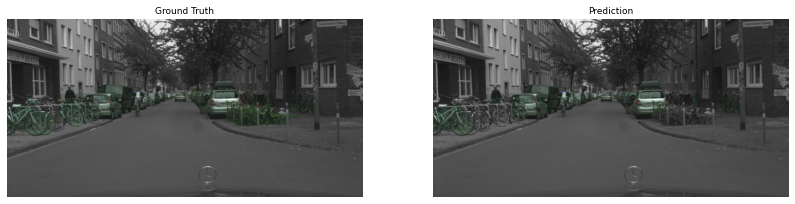

In [ ]:
gt_splash = color_splash(image, gt_mask)
pred_splash = color_splash(image, r['masks'])

visualize.display_images([gt_splash, pred_splash], titles=["Ground Truth", "Prediction"], cols=2)

In [ ]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR